<a href="https://colab.research.google.com/github/ZenQe/CV-Detection-Cats-and-Dogs/blob/main/Cat_and_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tarfile
import os
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import shutil
import torch.nn as nn
from skimage import io
import torchvision
import cv2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
# from torch.utils.data.sampler import SequentialSampler
from albumentations.pytorch import ToTensor
from torchvision import utils
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                           Compose, GaussNoise)
from PIL import Image

## Загрузка и предобработка данных

In [2]:
with tarfile.open('/content/drive/MyDrive/Colab Notebooks/cat_and_dog/cats_dogs_dataset.tar') as tar: #чтение в режиме чтения
  tar.extractall(path = './data')

In [3]:
data_dir = './data/cats_dogs_dataset'
print(os.listdir(data_dir))

['train', 'train_txt', 'valid', 'valid_txt']


In [4]:
#объединим тхт в датафрейм
def makedf(path, finaldf):
  data = []
  oslist = list(filter(lambda x: '.txt' in x, os.listdir(path)))
  files = [f for f in oslist]
  for f in files:
    with open (path+'/'+f, "r") as myfile:
      data.append(myfile.read())

  df = pd.DataFrame(data)
  #разделением по столбцам
  vs = pd.Series()
  for col in df.columns[~df.columns.isin(['row_name'])]:
      vs = vs.append(df[col].str.split('\s+'))

  tempdf = vs.groupby(vs.index).sum().to_frame()
  finaldf = pd.DataFrame(tempdf[0].values.tolist())
  #добавляем название фото
  finaldf.index = [x[:-4] for x in list(filter(lambda x: ('.txt' in x), os.listdir(path)))]
  finaldf = finaldf.reset_index()
  finaldf.columns = ['image_id', 'type_class', 'xmin', 'ymin', 'xmax', 'ymax']
  for col in finaldf.columns[-5:]:
    finaldf[col] = finaldf[col].astype('int64')
  finaldf['width'] = finaldf['xmax']-finaldf['xmin']
  finaldf['height'] = finaldf['ymax']-finaldf['ymin']
  return finaldf

In [5]:
df_valid = pd.DataFrame()
df_valid = makedf('./data/cats_dogs_dataset/valid_txt', df_valid)
df_train = pd.DataFrame()
df_train = makedf('./data/cats_dogs_dataset/train_txt', df_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if sys.path[0] == '':


In [6]:
#конвертируем дф в нужный формат
def converse(path, cor_df, finaldf):
  data = []
  oslist = os.listdir(path)
  for f in oslist:
    im = Image.open(path + f)
    (width, height) = im.size
    data.append([f[:-4],width, height])

  df = pd.DataFrame(data)
  df.columns = ['image_id', 'widthT', 'heightT']
  new_df = cor_df.merge(df, on = 'image_id')
  new_df = new_df[['image_id', 'widthT', 'heightT', 'type_class', 'xmin', 'ymin', 'width', 'height']]
  new_df = new_df.rename(columns={'widthT': 'width', 'heightT': 'height','xmin':'x', 'ymin':'y','width':'w', 'height':'h'})
  return new_df


In [7]:
final_valid = pd.DataFrame()
final_valid = converse('./data/cats_dogs_dataset/valid/', df_valid, final_valid)
final_train = pd.DataFrame()
final_train = converse('./data/cats_dogs_dataset/train/', df_train, final_train)

In [8]:
final_valid.head()

,image_id,width,height,type_class,x,y,w,h
0,english_setter_165,500,375,2,114,93,91,102
1,Sphynx_18,500,375,1,152,40,207,181
2,Russian_Blue_146,293,500,1,36,65,101,107
3,Bombay_186,250,292,1,30,54,190,192
4,shiba_inu_193,356,500,2,75,21,201,228


In [9]:
#Размерность выборок
print('valid', final_valid.shape)
print('train', final_train.shape)

valid (400, 8)
train (2985, 8)


## Подготовка данных для загрузки в модель

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
df_new = final_train
train_dir = './data/cats_dogs_dataset/train'

In [12]:
image_ids = df_new['image_id']
train_ids = image_ids[0:int(0.8*len(image_ids))]
val_ids = image_ids[int(0.8*len(image_ids)):]
print(f'Total images {len(image_ids)}')
print(f'No of train images {len(train_ids)}')
print(f'No of validation images {len(val_ids)}')

Total images 2985
No of train images 2388
No of validation images 597


In [13]:
train_df = df_new[df_new['image_id'].isin(train_ids)]
val_df = df_new[df_new['image_id'].isin(val_ids)]

In [14]:
def get_transforms(phase):
            list_transforms = []
            if phase == 'train':
                list_transforms.extend([
                       Flip(p=0.5)
                         ])
            list_transforms.extend(
                    [
            ToTensor(),
                    ])
            list_trfms = Compose(list_transforms,
                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
            return list_trfms

In [15]:
class Wheatset(Dataset):
    def __init__(self,data_frame,image_dir,phase='train'):
        super().__init__()
        self.df = data_frame
        self.image_dir = image_dir
        self.images = data_frame['image_id']
        self.transforms = get_transforms(phase)
        
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = self.images[idx] + '.jpg'
        
        image_arr = cv2.imread(os.path.join(self.image_dir,image), cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_arr /= 255.0
        image_id = str(image.split('.')[0])
        point = self.df[self.df['image_id'] == image_id]
        boxes = point[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        labels = torch.ones((point.shape[0],), dtype=torch.int64)
        class_labels = torch.as_tensor(point[['type_class']].values, dtype=torch.float32)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((point.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx)
        target['area'] = area
        target['iscrowd'] = iscrowd
        target['class_labels'] = class_labels
        
        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels'],
                'class_labels': target['class_labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
        target['boxes'] = torch.stack(tuple(map(torch.tensor, 
                                                zip(*sample['bboxes'])))).permute(1, 0)
        
        return image, target, image_id

In [16]:
train_data = Wheatset(train_df,train_dir,phase='train')
val_data = Wheatset(val_df,train_dir,phase='validation')

print(f'Length of train data {len(train_data)}')
print(f'Length of validation data {len(val_data)}')

Length of train data 2388
Length of validation data 597


In [17]:
# batching
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

In [18]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes'].numpy()
    for i in bb:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=2)
    plt.figure(figsize=(10,10))
    plt.imshow(image)

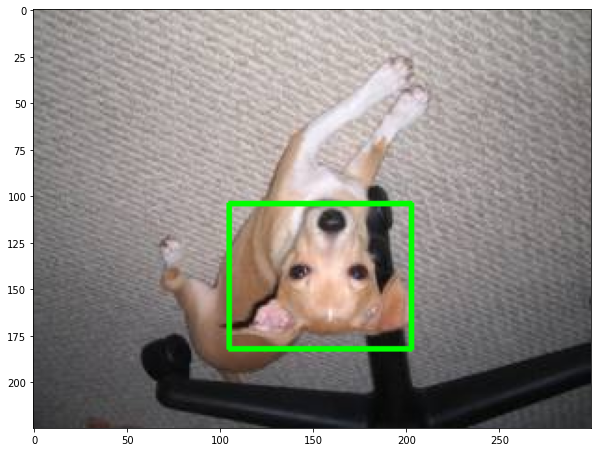

In [19]:
plot_img(train_data,10)

## Модель

In [20]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [21]:
num_classes = 3  # cat & dog & background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [22]:
images, targets, ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [23]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [24]:
# helper functions to save best model

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, checkpoint_path)
    # if it is a best model, min validation loss
    if is_best:
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [25]:
num_epochs = 5
train_loss_min = 0.9
total_train_loss = []

checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/cat_and_dog/checkpoint/checker'
best_model_path = '/content/drive/MyDrive/Colab Notebooks/cat_and_dog/bestmodel/bestmodel_may12.pt'

for epoch in range(num_epochs):
    print(f'Epoch :{epoch + 1}')
    start_time = time.time()
    train_loss = []
    model.train()
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss}')
      
    # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'train_loss_min': epoch_train_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    ## TODO: save the model if validation loss has decreased
    if epoch_train_loss <= train_loss_min:
            print('Train loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(train_loss_min,epoch_train_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            train_loss_min = epoch_train_loss
    
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch :1
Epoch train loss is 0.11316418870258743
Train loss decreased (0.900000 --> 0.113164).  Saving model ...
7m 47s
Epoch :2
Epoch train loss is 0.07133116060657456
Train loss decreased (0.113164 --> 0.071331).  Saving model ...
7m 48s
Epoch :3
Epoch train loss is 0.06125111786136422
Train loss decreased (0.071331 --> 0.061251).  Saving model ...
7m 47s
Epoch :4
Epoch train loss is 0.054562920449463745
Train loss decreased (0.061251 --> 0.054563).  Saving model ...
7m 48s
Epoch :5
Epoch train loss is 0.04957122626612131
Train loss decreased (0.054563 --> 0.049571).  Saving model ...
7m 47s


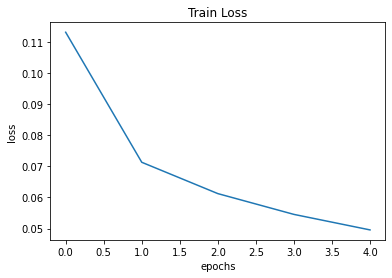

In [26]:
plt.title('Train Loss')
plt.plot(total_train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

## Тестовое случайное изоражение не из датасета

In [29]:
test_df = pd.DataFrame(final_train[:1])
test_df['image_id'][0]='sobaka-pes-labrador-trava-yazyk'
test_dir = '/content/drive/MyDrive/Colab Notebooks/cat_and_dog/test/'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
test_df2 = Wheatset(test_df,test_dir,phase='validation')

In [31]:
test_data_loader = DataLoader(
    test_df2,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

In [32]:
images, targets, image_ids = next(iter(test_df2))

In [33]:
test_dataset = Wheatset(test_df,test_dir, False)
test_data_loader = DataLoader( test_dataset, batch_size=1, shuffle=False) 

In [34]:
detection_threshold = 0.45

def format_prediction_string(boxes, scores): ## Define the formate for storing prediction results
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)


In [35]:
results=[]
model.eval()

for images, image_ids,_ in test_data_loader:    

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()    ##Formate of the output's box is [Xmin,Ymin,Xmax,Ymax]
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32) #Compare the score of output with the threshold and
        scores = scores[scores >= detection_threshold]                    #slelect only those boxes whose score is greater
                                                                          # than threshold value
                                                                                
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]         
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]         #Convert the box formate to [Xmin,Ymin,W,H]
          
        result = {                                     #Store the image id and boxes and scores in result dict.
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)  

In [36]:
sample = images[0].permute(1,2,0).cpu().numpy()
boxes = outputs[0]['boxes'].data.cpu().numpy()
scores = outputs[0]['scores'].data.cpu().numpy()

In [37]:
def test_img(data,idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes'].numpy()
    for i in boxes:
        cv2.rectangle(image, (boxes[0][0],boxes[0][1]), (boxes[0][2],boxes[0][3]), (0,255,0), thickness=2)
    plt.figure(figsize=(10,10))
    plt.imshow(image)

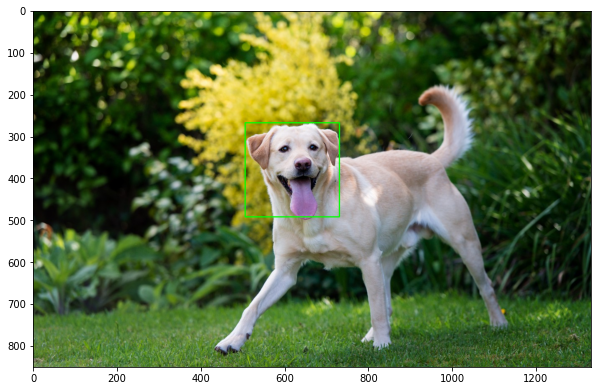

In [38]:
test_img(test_dataset,0)

## Valid

In [39]:
def max_convert(pred):
  if len(pred[0]) > 1:
    x = pred[1][np.where(pred[0]==pred[0].max())]
    return x[0]
  if pred[0].shape[0]==0:
    return np.zeros((1,4), dtype='int32')[0]
  else:
    return pred[1][0]

In [40]:
results=[]
model.eval()

for images, image_ids, names in valid_data_loader:    

      images = list(image.to(device) for image in images)
      outputs = model(images)

      for i, image in enumerate(images):

          boxes = outputs[i]['boxes'].data.cpu().numpy()    ##Formate of the output's box is [Xmin,Ymin,Xmax,Ymax]
          scores = outputs[i]['scores'].data.cpu().numpy()
          
          boxes = boxes[scores >= detection_threshold].astype(np.int32) #Compare the score of output with the threshold and
          scores = scores[scores >= detection_threshold]                    #slelect only those boxes whose score is greater
                                                                            # than threshold value
          image_id = image_ids[i]
          class_labels = image_ids[i]['class_labels'].numpy().astype(np.int32)[0][0]
          name_id = names[i]
          
          pred = [scores.astype(np.float32), boxes.astype(np.int32)]

          result = {                                     #Store the image id and boxes and scores in result dict.
              'image_id': name_id,
              'class_labels': class_labels,
              'PredictionString': max_convert(pred)
          }

          
          results.append(result)

In [41]:
val_df2 = pd.DataFrame(results)
val_df2.head()

,image_id,class_labels,PredictionString
0,english_setter_165,2,"[115, 94, 200, 193]"
1,Sphynx_18,1,"[146, 39, 368, 225]"
2,Russian_Blue_146,1,"[35, 66, 139, 173]"
3,Bombay_186,1,"[24, 45, 221, 246]"
4,shiba_inu_193,2,"[73, 20, 281, 251]"


In [55]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    cv2.rectangle(image, (int(val_df2['PredictionString'][idx][0]),
                              int(val_df2['PredictionString'][idx][1])),
                      (int(val_df2['PredictionString'][idx][2]),
                       int(val_df2['PredictionString'][idx][3])), (0,255,0), thickness=1)
    cv2.rectangle(image, (df_valid['xmin'][idx],
                              df_valid['ymin'][idx]),
                      (df_valid['xmax'][idx],
                       df_valid['ymax'][idx]), (255,0,0), thickness=1)

    plt.figure(figsize=(10,10))
    plt.imshow(image)

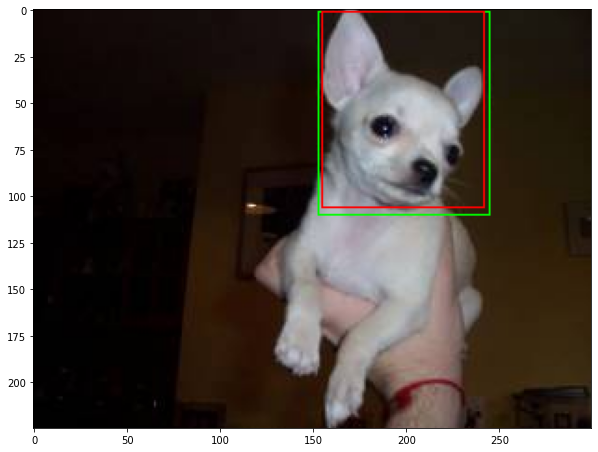

In [57]:
#Сравнение bbox предсказанного (зеленый) от исходного (красный)
plot_img(val_data2, 25)

## Итоговые параметры

In [44]:
# Точность классификатора
total_accuracy = accuracy_score(df_valid['type_class'], val_df2['class_labels'])
total_accuracy

1.0

In [45]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [46]:
val_df2.head()

,image_id,class_labels,PredictionString
0,english_setter_165,2,"[115, 94, 200, 193]"
1,Sphynx_18,1,"[146, 39, 368, 225]"
2,Russian_Blue_146,1,"[35, 66, 139, 173]"
3,Bombay_186,1,"[24, 45, 221, 246]"
4,shiba_inu_193,2,"[73, 20, 281, 251]"


In [47]:
df_valid['bbox'] = df_valid[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()

In [48]:
df_valid.head()

,image_id,type_class,xmin,ymin,xmax,ymax,width,height,bbox
0,english_setter_165,2,114,93,205,195,91,102,"[114, 93, 205, 195]"
1,Sphynx_18,1,152,40,359,221,207,181,"[152, 40, 359, 221]"
2,Russian_Blue_146,1,36,65,137,172,101,107,"[36, 65, 137, 172]"
3,Bombay_186,1,30,54,220,246,190,192,"[30, 54, 220, 246]"
4,shiba_inu_193,2,75,21,276,249,201,228,"[75, 21, 276, 249]"


In [49]:
miou = 0
for i in range(df_valid.shape[0]):
  miou += bb_intersection_over_union(df_valid['bbox'][i], val_df2['PredictionString'][i])
miou /= df_valid.shape[0]

In [50]:
miou

0.8883065409646127

In [51]:
%%time
for images, image_ids, names in valid_data_loader:    

      images = list(image.to(device) for image in images)
      outputs = model(images)

CPU times: user 32.7 s, sys: 554 ms, total: 33.2 s
Wall time: 33.3 s


In [52]:
print("mIoU {0:.2f}%, classification accuracy {1}%, 33.4 s, {2} train, {3} valid."
      .format(miou*100, total_accuracy*100, final_train.shape[0], final_valid.shape[0]))

mIoU 88.83%, classification accuracy 100.0%, 33.4 s, 2985 train, 400 valid.
